## predicting the health uninsured in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import utils

There are hundreds of variables in the PUMS dataset. Load in the variable names (code) and their descriptions (label) from the API.

In [2]:
# load variable names from census PUMS (public use microsample) API
codedict = utils.getCodeDictionary()

In [3]:
# load info on the codes for each state + DC that we need for our api calls
stateinfo = pd.read_csv('https://www2.census.gov/programs-surveys/acs/tech_docs/pums/top_coded_values/2019_pums_top_and_bottom_coded_values.csv')
stateinfo = stateinfo.loc[:, stateinfo.columns.isin(['BST','STATE'])]
print(stateinfo.tail())
# Drop Puerto Rico to keep it to 50 states
stateinfo = stateinfo[stateinfo.STATE != 'PR']
#print(stateinfo.tail())

    BST STATE
47   53    WA
48   54    WV
49   55    WI
50   56    WY
51   72    PR


When calling the Census API, a maximum of 50 variables can be requested at one time. The data are also easily accessed state-by-state. The PUMS represents ~1% of the population. If we want to use data from all states, we could start by subsampling from availbable records. Set the number of samples (nsamples) in getCensusDataByState().

One approach is to request data from a list of variables for a specific state in one call. The function callCensusAPI() below is meant to return a dataframe with variables in 'select_codes' from one state ('stateid'). A second function, getCensusDataByState() is meant to request data for all variables for one state in multiple calls and merge that data into one single dataframe for that state.

With the functions above, we can loop through our states of interest and save a dataframe for each if it does not exist locally yet.

In [4]:
datadir = os.path.join(os.getcwd(),"data")
try:
    os.mkdir(datadir)
except:
    print('')

Call API for states in loop and save csv locally if it doesn't exist yet

In [5]:
nsamples = 500
for state in stateinfo['BST']:
    state_id  =  f"{state:02}"
    fname = os.path.join(datadir,'state' + state_id + '_subsample' + str(nsamples) + '.csv')
    if os.path.exists(fname) == False:
        df,totalTime = utils.getCensusDataByState(state_id)
        df.to_csv(fname)
        print('state' + state_id + ': ' + str(totalTime))
        del df
        del fname
        del state_id

Load saved csv files.

In [6]:
filenames = glob.glob(os.path.join(datadir,'state' + '*' + str(nsamples) + '.csv'))
data_all  = pd.concat((pd.read_csv(file) for file in filenames)).reset_index(drop = True) # Import

print('shape of the subsampled dataframe: ' + str(data_all.shape[0]) + ' by ' + str(data_all.shape[1]))

shape of the subsampled dataframe: 25500 by 518


In [7]:
# check for extra columns that may have appeared from the dataframe merger:
for column in data_all:
    if column not in codedict.keys():
        if column.__contains__('.'):
            data_all.drop(column,axis=1,inplace=True)
        else:
            print('keeping ' + column)
print(data_all.shape)

keeping Unnamed: 0
keeping index
keeping state_x
keeping state_y
keeping state
(25500, 510)


In [8]:
# based on the way we merged state_x and state_y should be redundant
if data_all['state_x'].equals(data_all['state_y']):
    data_all.drop('state_y',inplace=True,axis=1)
# the state column should be incomplete based on the way we merged, drop if it has more missing values than 'state_x'
if data_all['state'].isna().sum() > data_all['state_x'].isna().sum():
    data_all.drop('state',axis=1,inplace=True)
# drop Unnamed: 0 because it's not useful at this point (from old indices)
data_all.drop('Unnamed: 0',axis=1,inplace=True)
# add state name from stateinfo to data_all for ease
data_all = data_all.merge(stateinfo,left_on='state_x',right_on='BST')
if data_all['state'].equals(data_all['BST']):
    data_all = data_all.drop('state',axis=1)

In [9]:
data_all[['state_x','STATE']].head()

,state_x,STATE
0,1,AL
1,1,AL
2,1,AL
3,1,AL
4,1,AL


Looks like we can just drop 'state_x' actually because the abbreviation should be good enough for us. 

In [10]:
data_all.drop(['state_x','BST','ST'],axis=1,inplace=True)

Now look for our target variable name. We want to know whether individuals had health insurance or not.

In [11]:
insurance_related = list()
for key, value in codedict.items():
    if value.__contains__('health insurance'):
        print(key + " : " + value)
        insurance_related.append(key)

PRIVCOV : private health insurance coverage recode
HICOV : health insurance coverage recode
FHICOVP : health insurance coverage recode allocation flag
FPRIVCOVP : private health insurance coverage recode allocation flag


let's check details on health insurance coverage recode

In [12]:
codename = 'HICOV'
details = utils.variableDetails(codename)
print('from ' + codename + ' : ')
for key,value in details['values']['item'].items():
    print(key, ':', value)

from HICOV : 
2 : No health insurance coverage
1 : With health insurance coverage


In [13]:
#plt.bar(range(len(df)), df["count"], color=plt.cm.Paired(np.arange(len(df))))

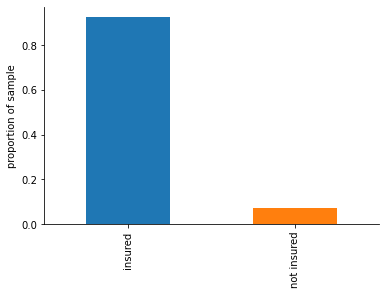

In [14]:
# relabel values to match no insurance (0) or insurance (1)
data_all[codename] = data_all[codename].replace({2:0})
data_all[codename].value_counts(normalize=True).plot.bar(color=['C0', 'C1'])
sns.despine()
plt.rc('font',size=20)
plt.ylabel('proportion of sample')
plt.xticks([0,1],['insured','not insured'])
plt.show()

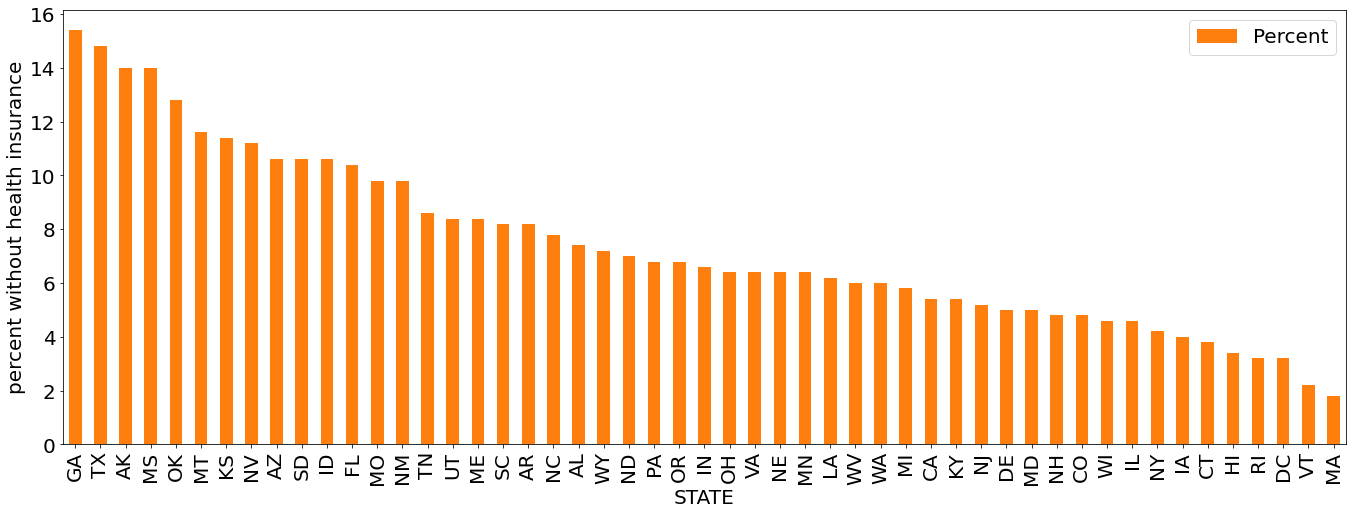

In [15]:
#plot percentage uninsured by state
insdf  = data_all.groupby('STATE')[codename].value_counts(normalize=True)
insdf  = insdf.mul(100).rename('Percent').reset_index()
insdf[insdf['HICOV'] == 0][['STATE','Percent']].sort_values('Percent',ascending=False).plot.bar(color=['C1'],x='STATE',y='Percent',figsize=(23,8))
plt.ylabel('percent without health insurance')
plt.show()

We can drop the other health insurance related columns because they are conceptually similar to our target variable.

In [16]:
for column in insurance_related:
    if column == 'HICOVP':
        continue
    else:
        data_all.drop(column,axis=1,inplace=True)

Now we can look to drop variables that have too many missing values.

In [17]:
missing_val = -1
thresh      = .33
for column in data_all:
    if any(data_all[column].isin([missing_val])):
        if data_all[column].isin([missing_val]).sum()/len(data_all[column]) > thresh:
            dets = utils.variableDetails(column)
            if dets['values']['item'][str(missing_val)].__contains__('N/A'):
                data_all.drop(column,axis=1,inplace=True)           

We also can check if most of the data in a column is the same, with very few records deviating.
If so, data may not be helpful/informative.

In [18]:
cnt = 0
thresh = 0.97
for column in data_all:
    prop = data_all[column].value_counts(normalize=True)
    if any(prop >= thresh):
        data_all.drop(column,axis=1,inplace=True) 

In [19]:
# check for other null or missing values
missing = pd.concat([data_all.isnull().sum(), 100 * data_all.isnull().mean()], axis=1)
missing.columns=['count', '%']
unqvals = missing['count'].unique()
if any(unqvals > 0):
    print('some missing values still')
else:
    print('no missing values')

no missing values


In [20]:
# save data_all to csv file
fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '.csv')
data_all.to_csv(fname)